In [1]:
%matplotlib inline
import numpy as np
import torch
torch.set_printoptions(edgeitems=2, linewidth=75)

섭씨 단위의 온도 데이터 노트를 만들고 새 온도계로 측정하면서 데이터를 수집하는 것

In [2]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0] # 섭씨 온도 
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4] # 알 수 없는 단위의 값 
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

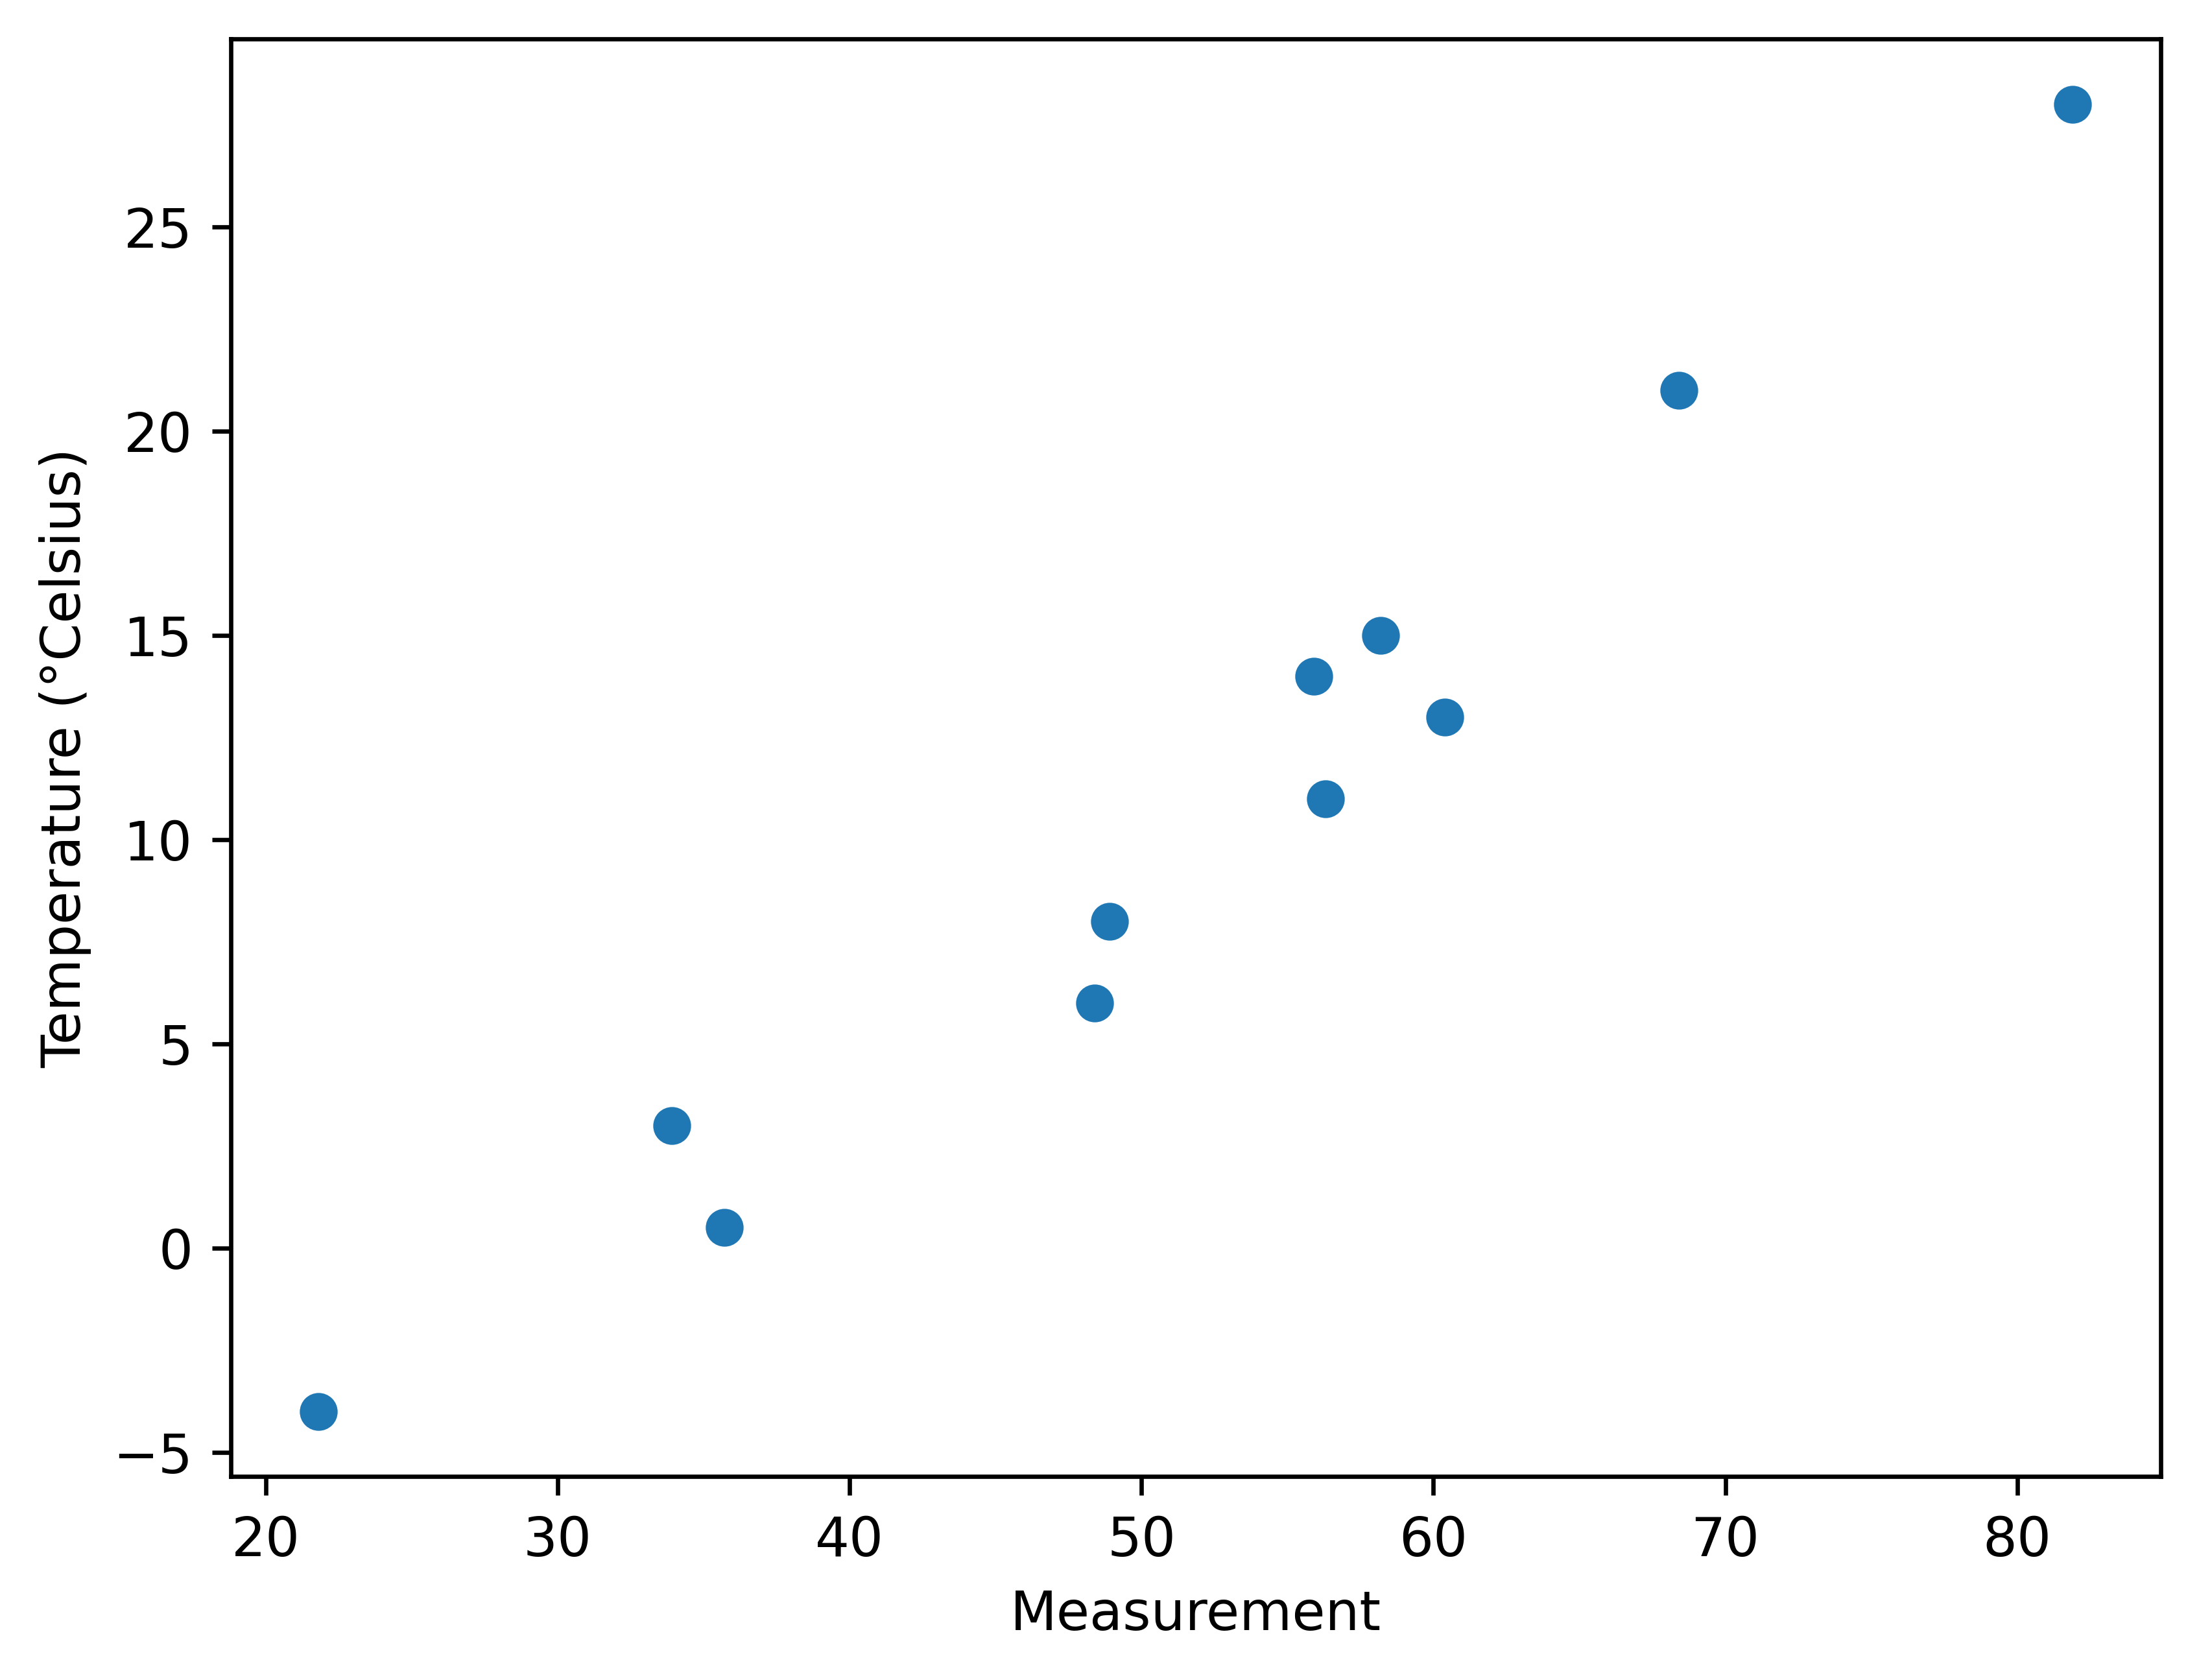

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt

fig = plt.figure(dpi=600)
plt.xlabel("Measurement")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

plt.savefig("temp_data_plot.png", format="png")
# 선형성을 가짐을 알 수 있음 

## 5.3.1 파이토치로 문제 풀어보기

In [5]:
def model(t_u, w, b): # 측정된 값, 가중치, 바이어스 
    return w * t_u + b

# mean square loss 
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

w = torch.ones(())
b = torch.zeros(())

t_p = model(t_u, w, b)
t_p # 모델이 예측한 값 

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000,
        21.8000, 48.4000, 60.4000, 68.4000])

In [6]:
# 오차
loss_fn(t_p, t_c)

tensor(1763.8848)

## 5.4.1 손실 줄이기

In [10]:
delta = 0.1 # x의 거리 delta -> 1/infinity = 아래의 과정은 기울기를 구하는 과정이 됨 

loss_rate_of_change_w = \
    (loss_fn(model(t_u, w + delta, b), t_c) - 
     loss_fn(model(t_u, w - delta, b), t_c)) / (2.0 * delta)

tensor(4517.2974)

In [11]:
learning_rate = 0.001

w - w - learning_rate * loss_rate_of_change_w

tensor(-4.5173)

In [ ]:
loss_rate_of_change_b = \
    (loss_fn(model(t_u, w, b + delta), t_c) - 
     loss_fn(model(t_u, w, b - delta), t_c)) / (2.0 * delta)

b = b - learning_rate * loss_rate_of_change_b

# 5.4.2 분석
- 2개 이상의 파라미터를 가진 모델에서는 각 파라미터에 대한 손실 함수의 편미분을 구하고, 이 편미분 값들을 미분 벡터에 넣음 = 기울기

In [15]:
def dloss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs

# 5.4.3 모델 적합을 위한 반복

In [ ]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        t_p = model(t_u, w, b)  # <1>
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)  # <2>

        params = params - learning_rate * grad

        print('Epoch %d, Loss %f' % (epoch, float(loss))) # <3>
            
    return params

## 5.5.1 기울기 자동 계산 

In [16]:
t_un = 0.1 * t_u # 대충 정규화라고 치는 것

In [17]:
def model(t_u, w, b):
    return w * t_u + b

In [18]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [20]:
# 파라미터 텐서 초기화
params = torch.tensor([1.0, 0.0], requires_grad=True) 
# 1.0 = 가중치의 초기값
# 0.0 = bias 초기값 

In [21]:
params.grad is None

True

In [22]:
loss = loss_fn(model(t_u, *params), t_c)
loss.backward() # loss텐서에 대해서 backward 호출 

In [23]:
params.grad # 각 요소에 대한 손실값의 미분

tensor([4517.2969,   82.6000])

In [24]:
if params.grad is not None:
    params.grad.zero_()

In [25]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None:  # bakward 호출 전에 하기
            params.grad.zero_()
        
        t_p = model(t_u, *params) 
        loss = loss_fn(t_p, t_c)
        loss.backward()
        
        with torch.no_grad():  # 파라미터 조정이 no_grad 내에서만 이루어지도록 
            params -= learning_rate * params.grad

        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            
    return params

In [27]:
training_loop(
    n_epochs = 5000, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 0.0], requires_grad=True), # grad 중요!
    t_u = t_un, # 정규화된 값 사용하기
    t_c = t_c)

Epoch 500, Loss 7.860115
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

## 5.5.2 골라쓰는 옵티마이저

In [28]:
import torch.optim as optim

In [29]:
dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'NAdam',
 'Optimizer',
 'RAdam',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional',
 '_multi_tensor',
 'lr_scheduler',
 'swa_utils']

In [32]:
# 경사하강 옵티마이저 사용하기
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-5
optimizer = optim.SGD([params], lr=learning_rate)

In [33]:
t_p = model(t_u, *params)
loss = loss_fn(t_p, t_c)

optimizer.zero_grad()
loss.backward()
optimizer.step()

params

tensor([ 9.5483e-01, -8.2600e-04], requires_grad=True)

In [34]:
def training_loop(n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
    
    return params

In [37]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

training_loop(
    n_epochs = 5000, 
    optimizer= optimizer,
    params = params, 
    t_u = t_un, # 정규화된 값 사용  
    t_c = t_c
)

Epoch 500, Loss 7.860115
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

In [40]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-1 # 학습률 더 올리기 
optimizer = optim.Adam([params], lr=learning_rate)

training_loop(
    n_epochs = 2000, 
    optimizer= optimizer,
    params = params, 
    t_u = t_u, # 원래 입력인 t_u를 사용 -> 파라미터 비율 조정에도 덜 영향을 받기때문에 정규화 안시켜줘도 성능이 나옴 
    t_c = t_c
)

Epoch 500, Loss 7.612898
Epoch 1000, Loss 3.086700
Epoch 1500, Loss 2.928579
Epoch 2000, Loss 2.927644


tensor([  0.5367, -17.3021], requires_grad=True)

## 5.5.3 훈련, 검증, 과적합
- 데이터의 일부를 따로 떼어 validation set만들기

In [44]:
# 데이터셋 나누기 
n_samples = t_u.shape[0] # 샘플 개수
n_val = int(0.2 * n_samples) # validation 비율 즉 train과 validation을 8:2로 하기위해 n_val 선언 

shuffled_indices = torch.randperm(n_samples)
# randperm 함수는 색인 순열을 찾기 위해 텐서 요소를 섞어쓸 때의 인덱스 리스트를 반환 

train_indices = shuffled_indices[:-n_val] # 둘 다 인덱스만 갖고 있는 것 
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices 

(tensor([ 5,  9,  3,  6,  0,  4, 10,  7,  1]), tensor([2, 8]))

In [50]:
train_t_un = t_un[train_indices] # 정규화된 데이터 사용
train_t_c = t_c[train_indices]

val_t_un = t_un[val_indices]
val_t_c = t_c[val_indices]

In [53]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params) # train
        train_loss = loss_fn(train_t_p, train_t_c)
                             
        val_t_p = model(val_t_u, *params) # validation
        val_loss = loss_fn(val_t_p, val_t_c)
        
        optimizer.zero_grad()
        train_loss.backward() # 학습은 무조건 train으로만
        optimizer.step()

        if epoch <= 3 or epoch % 500 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                  f" Validation loss {val_loss.item():.4f}")
            
    return params

In [54]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    params = params,
    train_t_u = train_t_un, 
    val_t_u = val_t_un, 
    train_t_c = train_t_c,
    val_t_c = val_t_c)

Epoch 1, Training loss 88.7100, Validation loss 42.8090
Epoch 2, Training loss 41.4218, Validation loss 13.5269
Epoch 3, Training loss 34.1070, Validation loss 12.9835
Epoch 500, Training loss 6.6346, Validation loss 7.8649
Epoch 1000, Training loss 3.1442, Validation loss 5.6421
Epoch 1500, Training loss 2.6852, Validation loss 4.9298
Epoch 2000, Training loss 2.6249, Validation loss 4.6839
Epoch 2500, Training loss 2.6170, Validation loss 4.5963
Epoch 3000, Training loss 2.6159, Validation loss 4.5647


tensor([  5.3056, -16.8024], requires_grad=True)

## 5.5.4 자동미분 끄기

In [55]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u,
                  train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)

        with torch.no_grad(): # <1>
            val_t_p = model(val_t_u, *params)
            val_loss = loss_fn(val_t_p, val_t_c)
            assert val_loss.requires_grad == False # <2>
            
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

In [56]:
def calc_forward(t_u, t_c, is_train):
    with torch.set_grad_enabled(is_train):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
    return loss